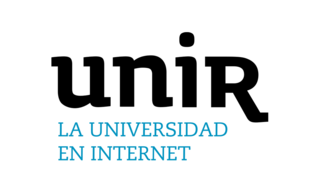

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [8]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.7.0+cpu
Lightkurve: 2.5.0


| Fuente       | Misión | Etiquetado | Tipo         | Método de acceso                   |
| ------------ | ------ | ---------- | ------------ | ---------------------------------- |
| Kepler EB    | Kepler | Sí         | Binaries     | NASA Exoplanet Archive / Villanova |
| K2VARCAT     | K2     | Sí         | Multiclase   | MAST HLSP                          |
| TESS-SVC     | TESS   | Semi       | Variabilidad | MAST HLSP                          |
| TESS-EB      | TESS   | Sí         | EB continuas | MAST HLSP                          |
| VSX (AAVSO)  | Todos  | Sí         | Multiclase   | AAVSO + MAST                       |
| Gaia DR3 Var | Todos  | Sí         | Multiclase   | ESA Gaia Archive                   |

Diseño del esquema del dataset. Vamos a unificar las curvas descargadas en un dataset estructurado tipo CSV/Parquet con este esquema mínimo:

| id\_mision | id\_objeto | mision | clase\_variable | fecha\_inicio | fecha\_fin | tiempo | magnitud | error | origen\_etiqueta |
| ---------- | ---------- | ------ | --------------- | ------------- | ---------- | ------ | -------- | ----- | ---------------- |

Estrategia de implementación técnica
Podemos hacerlo en varias etapas:

- Script 1: descarga de curvas etiquetadas de Kepler EB y TESS-EB (usando ID + clase desde CSV original)
- Script 2: procesamiento de K2VARCAT (CSV disponible con clase + ID)
- Script 3: combinación cruzada entre TIC (TESS Input Catalog) y VSX (requiere posiciones celestes + nombre)
- Script 4: cruce de Gaia DR3 variables con coordenadas de Kepler/K2/TESS
- Script 5: exportación consolidada en formato CSV/Parquet final con clases normalizadas

# 📥 Descarga y consolidación de curvas EB (entorno local o SageMaker)
Esta sección permite ejecutar el script `script_1_eb.py`, ya sea con el catálogo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.


In [ ]:
# 1) Lanzando el script de ejemplo directamente
# !python src/script_1_eb.py

import sys, platform
from pathlib import Path

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_1_eb import main as run_script_1

# Detectar entorno y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

# Ejecutar con la opción adecuada
if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    run_script_1(use_sample=False)
else:
    print("💻 Ejecutando en entorno local → catálogo de prueba")
    run_script_1(use_sample=True)

In [ ]:
# Cargar y explorar el resultado
import pandas as pd

dataset_path = Path("data/processed/dataset_eb.parquet")
if dataset_path.exists():
    df = pd.read_parquet(dataset_path)
    display(df.head())

    n_estrellas = df["id_objeto"].nunique()
    n_filas = df.shape[0]

    print(f"[✓] Número de estrellas descargadas y consolidadas: {n_estrellas}")
    print(f"[✓] Total de filas (puntos de curva): {n_filas:,}")

    curvas_por_estrella = df["id_objeto"].value_counts()
    print(f"[✓] Curvas por estrella (máx): {curvas_por_estrella.max()}")

    # Conteo por clase (en este caso todas deberían ser 'EB')
    print("\n[✓] Recuento por clase_variable:")
    print(df.groupby("clase_variable")["id_objeto"].nunique())

else:
    print("[⚠️] El archivo Parquet no se encontró. ¿Falló la descarga o consolidación?")

In [ ]:
from src.utils.cleanup_raw import cleanup_raw_data

# Limpiar los datos de prueba
cleanup_raw_data(confirm=True)